# Project Topic

The goal of this project is to analyze motorcycle emission data and explore the possibility of predicting the emission of a motorcycle based on its technical characteristics.

# Data

## Data Source and access
The data used in this project is provided by the Federal Roads Office of Switzerland (FEDRO). FEDRO is responsible for the planning, construction, and maintenance of the Swiss national road network. The office collects and maintains data on road traffic, vehicle registrations, and emissions to monitor the environmental impact of road transport and to inform policy decisions.

The data collected by FEDRO during vehicle registrations and as part of the process governing the introduction of new vehicle models into the Swiss market is the primary data source for this project.

Most of FEDRO's traffic- and vehicle data is available as part of Switzerland's OpenData initiative, but certain attributes are withheld from the publicly accessible data sets and are only provided on a subscription basis.

The Open Data sets are available in multiple formats and at different levels of processing and transformation, including the raw format used by the organization itself. All of these data sets can be downloaded from one of the subdirectories of the FEDRO's OpenData portal: https://www.ivz-opendata.ch/opendata/

Further information on the various forms of available data can be found on the Federal Roads Office of Switzerland's website.

Data source citation:
- Bundesamt für Strassen FEDRO (2024) Vehicle Information Products. Available at: https://www.astra.admin.ch/astra/en/home/documentation/data-and-information-products/vehicle-information-products.html (Accessed: 15th February 2024).

## Data Description
The data required for this project is provided in two separate files. These files are extracts from the full vehicle database, created by the data owner: FEDRO. The first file contains the technical attributes of each motorcycle model introduced to the Swiss market. The second file contains the emissions data for all road vehicle models registered in Switzerland.

The detailed description of the technical data set is available on the FEDRO's website.: https://www.ivz-opendata.ch/opendata/2000-Typengenehmigungen_TG_TARGA/2200-Basisdaten_TG_ab_1995/2220-Datenbeschreibung/Basisdaten_TG_ab_1995.pdf


### Technical Attributes Data

The data set used for vehicle technical attributes in this project is the `TG-Moto.txt` file from the `2000-Typengenehmigungen_TG_TARGA/2200-Basisdaten_TG_ab_1995/` directory.
URL: https://www.ivz-opendata.ch/opendata/2000-Typengenehmigungen_TG_TARGA/2200-Basisdaten_TG_ab_1995/TG-Moto.txt
 
The data is in tab-separated values (TSV) format.
The file contains 224 columns and 10065 rows, excluding the header row. The columns contain information about the motorcycle model, such as the manufacturer, model name, engine type, engine capacity, exhaust system types, noise emission categories and other technical attributes.

### Emissions Data

The data set used for vehicle emissions in this project is the `emissionen.txt` file from the `2000-Typengenehmigungen_TG_TARGA/2200-Basisdaten_TG_ab_1995/` directory.
URL: https://www.ivz-opendata.ch/opendata/2000-Typengenehmigungen_TG_TARGA/2200-Basisdaten_TG_ab_1995/emissionen.txt

The data is in tab-separated values (TSV) format.
The file contains 47 columns and 269245 rows, excluding the header row. 

The emissions data corresponds to the vehicle models registered in Switzerland and can be joined with the technical attributes data set using the `TG-Code` column, which is a unique identifier for each vehicle model.

Besides the basic ID data of the vehicle model, the file includes emissions data for primary and secondary fuel sources, such as CO2, NOx, HC, and PM emissions. 

However, fuel consumption data is not included, and CO2 emissions are only available for cars and trucks, not for motorcycles.

The detailed description of the emission data set is available on the FEDRO's website.: https://www.ivz-opendata.ch/opendata/2000-Typengenehmigungen_TG_TARGA/2200-Basisdaten_TG_ab_1995/2220-Datenbeschreibung/Emissionen_TG_ab_1995.pdf  

# Data cleaning

The data files can be accessed from the VIZ OpenData portal by manual download, but API access is not available. However, programmatic access to the data can be achieved by using wget or similar tools to download the files directly from the portal. To make sure that this notebook runs without issues, the data files are provided as part of the project materials, and the code will load the data from the local directory.

## Loading the data
Since both files are tab-separated values (TSV) files, they can be read into a pandas DataFrame using the read_csv() function, but there are certain considerations to keep in mind:

- The files contain non-ASCII characters, but they are not UTF-8 encoded, so the encoding parameter should be set to 'windows-1252'.
- The files may contain missing values, but setting the na_values parameter to 'NA' will not ensure correct handling, because the file structure of the emissions data is the same for motorcycles, cars and trailers, but not all attributes are available for all vehicle types. This means that missing values are not consistently represented across the dataset. In certain cases the entire column can be removed, and those columns are unnamed in the data files.
- The field separator is a tab character, so the sep parameter should be set to '\t'.
- The files need to be merged based on a shared key, the "type approval code", and the column is named differently in each file.

In [1]:
import pandas as pd

# Load the "Type approval" data into a DataFrame
tg_file_path = 'data/TG-Moto.txt'
tg_data = pd.read_csv(tg_file_path, delimiter='\t', encoding='windows-1252', header=0, low_memory=False)
# Load the emissions data into a DataFrame
em_file_path = 'data/emissionen.txt'
em_data = pd.read_csv(em_file_path, delimiter='\t', encoding='windows-1252', header=0, low_memory=False)
# Merge the datasets based on the Type Approval Code
merged_data = pd.merge(tg_data, em_data, left_on='Typengenehmigungsnummer', right_on='TG-Code', how='inner')

Pandas may show a warning message as it encounters mixed types in a column with the 'object' data type. This is due to the nature of the data in many columns of the dataset, as there are certain identifiers and codes which may or may not include non-numeric characters, but the values can be valid in either case.
 Setting the `low_memory` parameter to false helps in avoiding these warnings, but doesn't guarantee that Pandas will guess the data type correctly. 
 
To address this, the columns with mixed types will be converted to strings in the next step.
With the two datasets merged, the empty columns can be dropped and some of the data types can be corrected.

The merge also eliminates missing emissions data thanks to the inner join, but there may still be missing values in the technical attributes data. These missing values will be handled in the next steps.

With the two datasets merged, the empty columns can be dropped and some of the data types can be corrected.
Dropping certain columns is necessary, because the same data structure is used for multiple vehicle types, and of course not all attributes are applicable to motorcycles.



In [2]:

# Identify any columns with unnamed headers
unnamed_columns = [col for col in merged_data.columns if 'Unnamed' in col]

# Check if these unnamed columns contain only NaN values
empty_columns = [col for col in unnamed_columns if merged_data[col].isna().all()]
# Drop the empty columns
merged_data = merged_data.drop(columns=empty_columns)
# Drop duplicate rows
merged_data = merged_data.drop_duplicates()

for column in merged_data.columns:
    if merged_data[column].dtype == object:
        # Check if there are mixed types within this 'object' column
        mixed = merged_data[column].apply(type).nunique() > 1
        if mixed:
            # Convert this column to string
            merged_data[column] = merged_data[column].astype(str)

The date format in the dataset is 'YYYYMMDD', which can be easily mistaken for numeric data.

However, the data set descriptions provided by FEDRO confirm that certain columns represent dates. These columns will be converted to datetime objects to ensure that they are treated as dates in the analysis.

In [3]:
# These columns are dates according to the data set description
date_columns = ['Typengenehmigung erteilt',
                'gültig für Importdatum bis',
                'Erweiterung TG vom:',
                'Homologationsdatum']

# Convert these columns to datetime
for column in date_columns:
    merged_data[column] = pd.to_datetime(merged_data[column].astype(str), format='%Y%m%d', errors='coerce')

At this point the data set should be cleaned and transformed to a state where it is ready for exploratory data analysis.

It is a good idea to save the cleaned data set to a new file, so that the cleaning process does not need to be repeated every time the notebook is run.
This step is for convenience and therefore optional.


In [4]:
cleaned_data_path = 'data/cleaned_data.csv'
merged_data.to_csv(cleaned_data_path, index=False, mode='w')

# Exploratory Data Analysis

## Overview
With the data cleaned and transformed, the next step is to perform exploratory data analysis (EDA) to gain insights into the dataset. 

Since the goal of the project is to predict motorcycle emissions based on their characteristics, the EDA should focus on understanding the relationships between the features and the target variables.

Let's look at the target variables. The emission data set contains both gas- and noise pollution data. The gas pollution data includes the following columns:

Primary fuel pollutants:
- ET-CO: Carbon Monoxide Emissions (g/km)
- ET-THC: Total Hydrocarbon Emissions (g/km)
- ET-NOx: Nitrogen Oxides Emissions (g/km)
- ET-THC+NOx: Total Hydrocarbon and Nitrogen Oxides Emissions (g/km)
- ET-PM: Particulate Matter Emissions (g/km)
(ET stands for Ersttreibstoff, which means primary fuel in German)

Secondary fuel pollutants:
- ZT-CO2: Carbon Monoxide Emissions (g/km) (Misleading column name, should be CO)
- ZT-THC: Total Hydrocarbon Emissions (g/km)
- ZT-NOx: Nitrogen Oxides Emissions (g/km)
- ZT-THC+NOx: Total Hydrocarbon and Nitrogen Oxides Emissions (g/km)
- ZT-PM: Particulate Matter Emissions (g/km)
(ZT stands for Zweittreibstoff, which means secondary fuel in German)

Since secondary fuel pollutants are not relevant for motorcycles, we will focus on the primary fuel pollutants in this analysis.

For more information on the standard pollution metrics, please refer to the [European Union's Regulation (EC) No 715/2007](https://eur-lex.europa.eu/legal-content/EN/TXT/PDF/?uri=CELEX:32007R0715&from=EN), or for a more interesting read, the Nature article on [Vehicle criteria pollutant (PM, NOx, CO, HCs) emissions: how low should we go?](https://www.nature.com/articles/s41612-018-0037-5) 

In the next section, we will explore the distribution of these emissions data and identify any patterns or outliers that may need to be addressed during the data preprocessing stage.


## Distribution



In the next section, we will explore the distribution of the emissions data and identify any patterns or outliers that may need to be addressed during the data preprocessing stage.

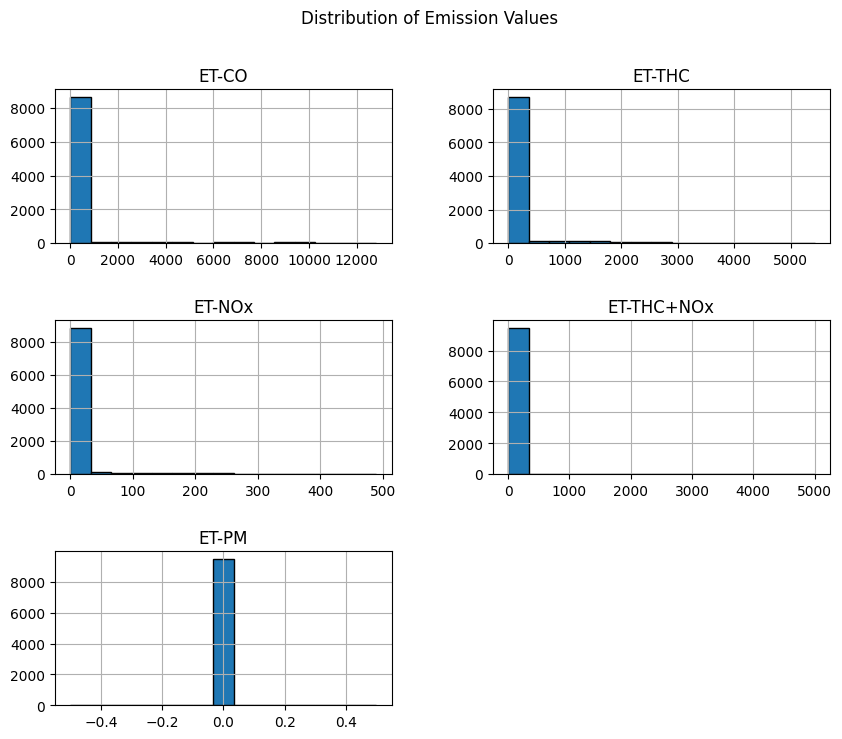

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

emission_cols = ['ET-CO', 'ET-THC', 'ET-NOx', 'ET-THC+NOx', 'ET-PM']
emission_data = merged_data[emission_cols]

# Plot histograms for each emission type
emission_data.hist(bins=15, figsize=(10, 8), layout=(3, 2), edgecolor='black')
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Distribution of Emission Values')
plt.show()

The histograms show that the emissions data is right-skewed, with most values concentrated at the lower end of the scale. This is expected, as modern vehicles are designed to be more fuel-efficient and environmentally friendly.

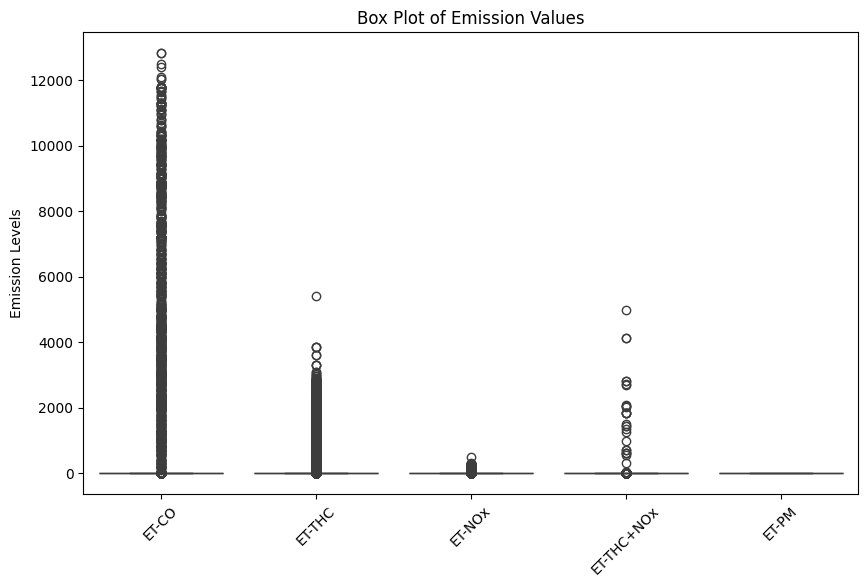

In [6]:
# Plot box plots for each emission type
plt.figure(figsize=(10, 6))
sns.boxplot(data=emission_data)
plt.title('Box Plot of Emission Values')
plt.ylabel('Emission Levels')
plt.xticks(rotation=45)
plt.show()

The box plots show that there are some outliers in the data, particularly for the ET-THC+NOx (Total Hydrocarbon and Nitrogen Oxides Emissions) columns. These outliers may need to be addressed later.

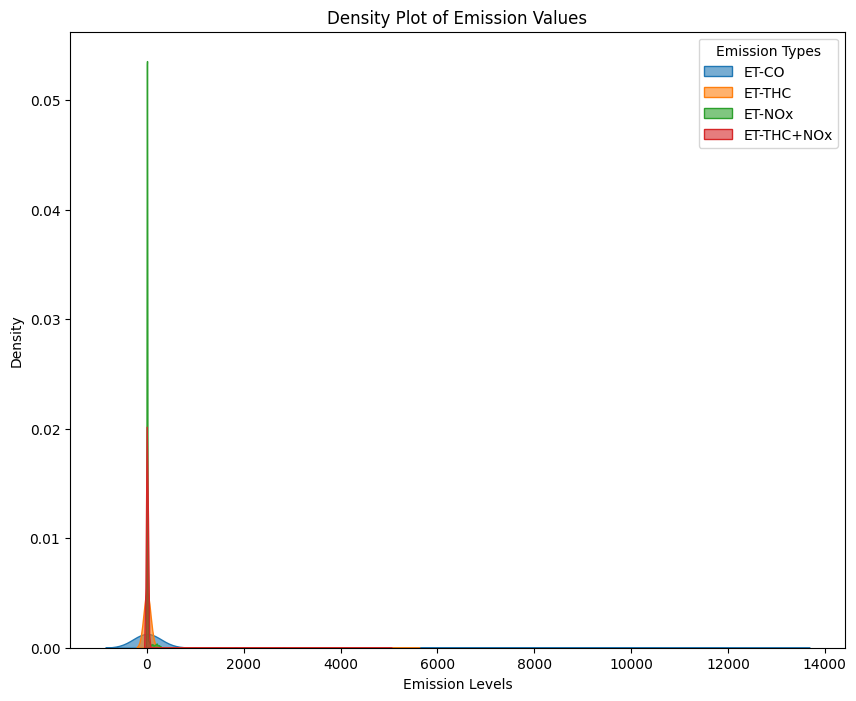

In [7]:
# Plot density plots for each emission type
plt.figure(figsize=(10, 8))
for col in emission_cols:
    sns.kdeplot(merged_data[col], fill=True, common_norm=False, alpha=0.6, label=f'{col}', warn_singular=False)
plt.title('Density Plot of Emission Values')
plt.xlabel('Emission Levels')
plt.legend(title='Emission Types')
plt.show()

The density plots show the distribution of emissions data more clearly, with each emission type having a distinct shape. 

## Correlation

Let's look at some correlations in the data set. The goal is to identify any relationships between the technical attributes of the motorcycles and their emissions. This will help us understand which features are most important for predicting emissions.

Before we can calculate the correlation matrix, we need to preprocess the data further to handle missing values. Since there are too many columns with non-numeric data, we will focus on the numeric columns for now.

In [8]:
import numpy as np
# Get the numeric data and remove NaN as much as possible
numeric_data = merged_data.select_dtypes(include=[np.number])
numeric_data = numeric_data.dropna(axis=1, how='all') 
numeric_data = numeric_data.dropna(axis=0, how='any') 

correlation_matrix = numeric_data.corr()

# Even though we removed the columns with all NaN values, there may still be some NaN values in the correlation matrix itself
correlation_matrix = correlation_matrix.dropna(axis=1, how='all')
correlation_matrix = correlation_matrix.dropna(axis=0, how='any')

# Set display options, to be able to show all available data
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(correlation_matrix)

                            01 EFKO-Code  02 Fahrzeugsubart Code  \
01 EFKO-Code                    1.000000                0.860945   
02 Fahrzeugsubart Code          0.860945                1.000000   
07 Karosserieform Code          0.063310               -0.024689   
10 EFKO-Code                    0.020321                0.037203   
16 Fahrzeug Vmax mech von      -0.221497               -0.114695   
16 Fahrzeug Vmax autom von     -0.005999               -0.001561   
16 Fahrzeug Vmax autom bis      0.052923                0.024563   
23 Hubraum                     -0.113329               -0.033118   
24 Leistung kW                 -0.037606                0.017068   
24 Leistung n                  -0.139328               -0.075815   
25 Md. max Nm                  -0.057808                0.005520   
25 Md. max n                   -0.045097               -0.019289   
35 Länge von                    0.287315                0.346187   
35 Länge bis                    0.152285        

The correlation matrix shows the relationships between the numerical features in the dataset but a heatmap visualization will make it easier to interpret the results.

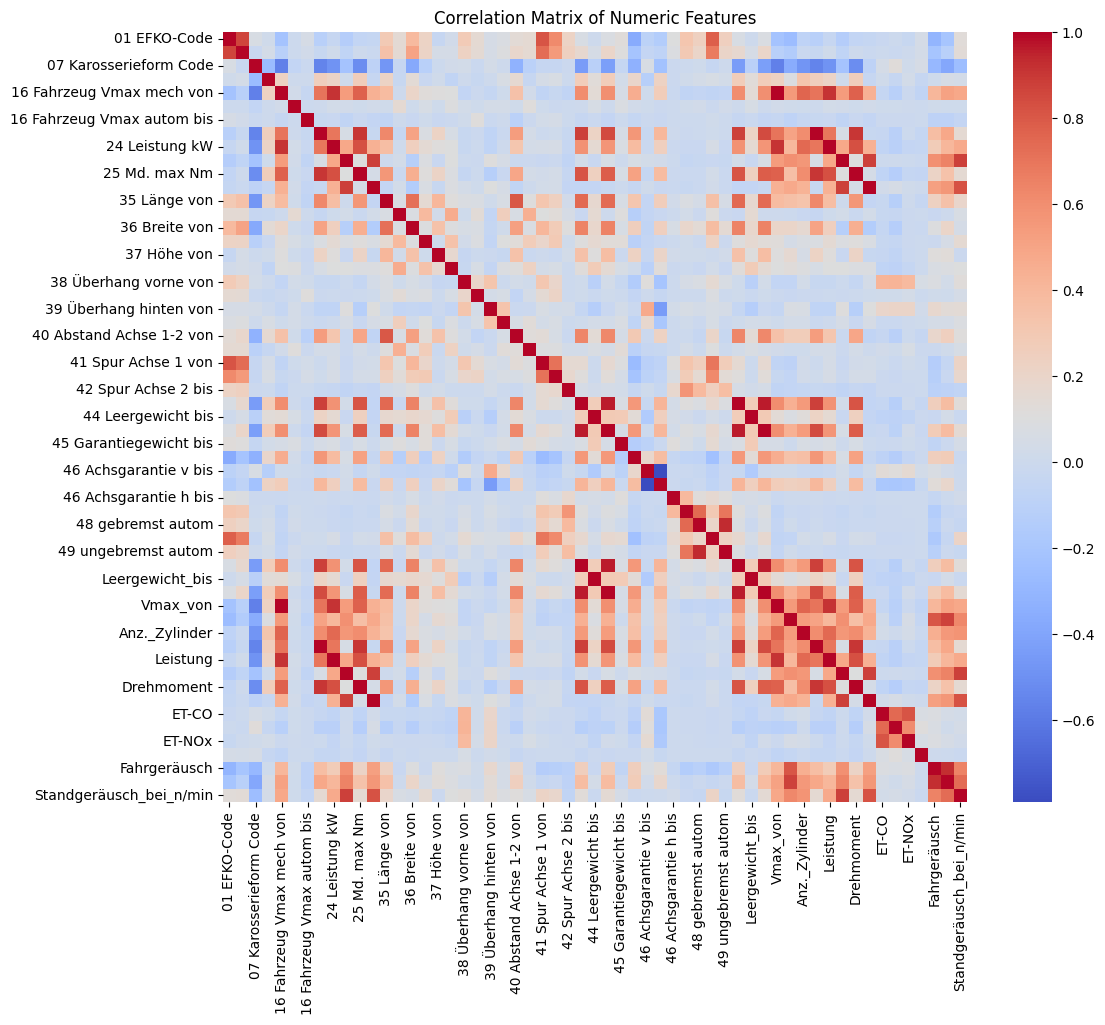

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

This heatmap is a bit hard to read due to the large number of features and the complexity of the relationships. However, it provides a good overview of the correlations between the numerical features in the dataset. We can make it a bit more understandable by grouping the features based on their correlations.


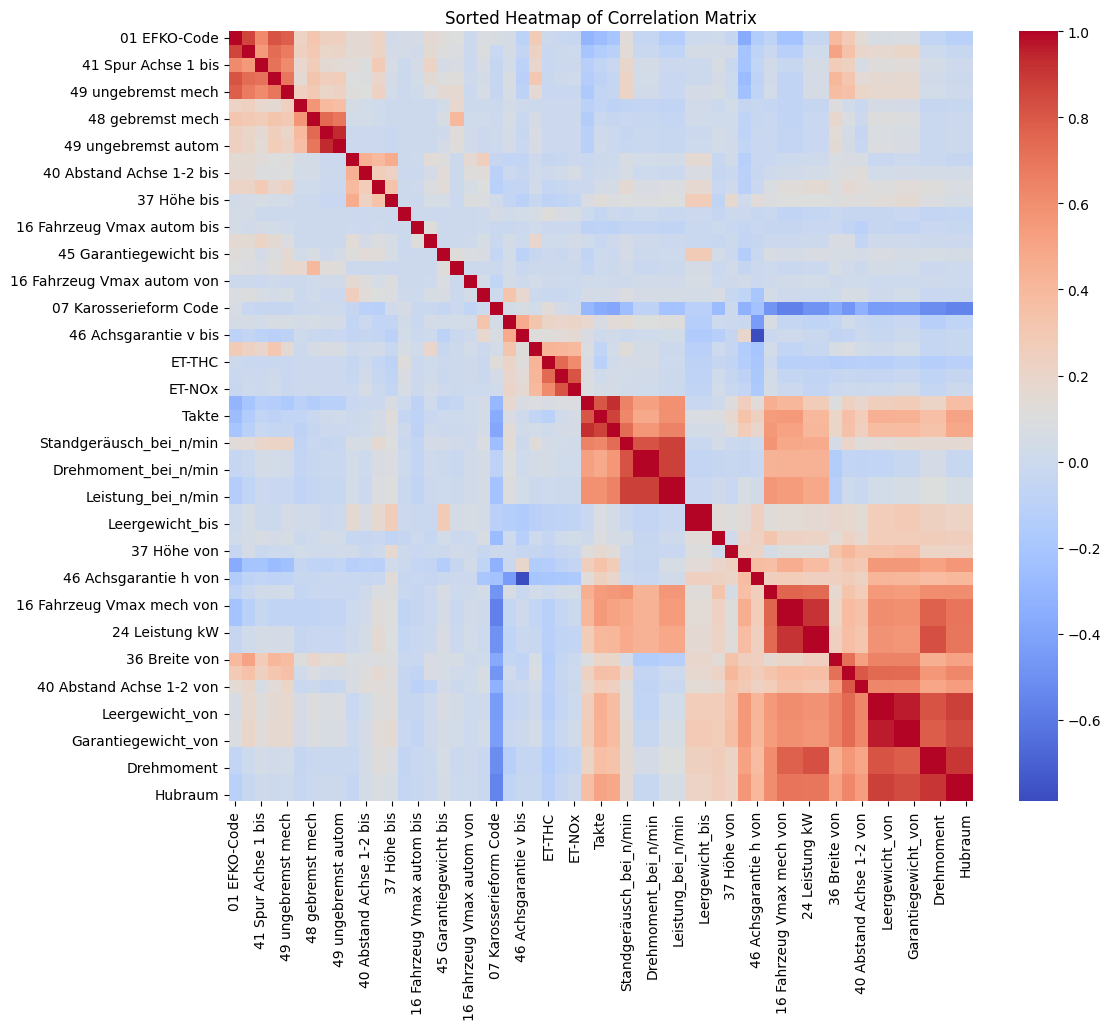

In [10]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list

# Generate the linkage matrix
link = linkage(correlation_matrix, method='ward')
order = leaves_list(link)

sorted_corr_matrix = correlation_matrix.iloc[order, order]

plt.figure(figsize=(12, 10))
sns.heatmap(sorted_corr_matrix, annot=False, cmap='coolwarm')
plt.title('Sorted Heatmap of Correlation Matrix')
plt.show()

Based on the heatmap, the emission-related columns are not highly correlated with the numeric technical attributes of the motorcycles. This suggests that the emissions are influenced by a combination of factors rather than a single feature. It is also possible that the attributes truly influencing the emissions are the categorical attributes in the dataset. 
What made this discovery particularly interesting is that instinctively, I would have expected the emissions to be at least somewhat correlated to the engine displacement, power, or weight of the motorcycles. However, the data suggests that the emissions are influenced by a combination of factors that are not directly related to the engine specifications.

To find out, I attempted to build a logistic regression model to predict the emissions based on the technical attributes of the motorcycles.

To be able to use the categorical features in the model, we need to encode them using one-hot encoding. But first, let's categorize the emission columns based on their values to simplify the model.
I will categorize the emissions using a quantile based binning to end up with 'Low', 'Medium', 'High', and 'Very High' values for each emission column.




In [11]:
# Select the emission columns, still focusing on primary fuel source
emission_columns = ['ET-CO', 'ET-THC', 'ET-NOx', 'ET-THC+NOx', 'ET-PM']

category_columns = []
# Loop over each emission column to apply quantile-based binning
for column in emission_columns:
    # Check the number of unique values
    unique_vals = merged_data[column].nunique()

    # Determine the number of quantiles based on unique values
    num_quantiles = min(4, unique_vals)  # Ensure we do not exceed the number of unique values
    print(f'{unique_vals} unique values and {num_quantiles} in {column}')

    category_columns.append(f'{column}_Category')
    merged_data[f'{column}_Category'] = pd.qcut(merged_data[column], q=num_quantiles, duplicates='drop')
    quantile_bounds = pd.qcut(merged_data[column], q=num_quantiles, retbins=True, duplicates='drop')[1]
    print(f'Quantile bounds for {column}: {quantile_bounds}')

# Display the first few entries to verify categorization
print(merged_data.head())


# Let's define a human-readable name for each category. There are 4 categories, so we will use 'Low', 'Medium', 'High', and 'Very High'
# Each category column may have a different number of categories, so we will define the categories separately for each column
# Those that only have 2 categories will be labeled as 'Low' and 'High'
# Those with 3 categories will be labeled as 'Low', 'Medium', and 'High'
# Those with 4 categories will be labeled as 'Low', 'Medium', 'High', and 'Very High'
for column in category_columns:
    unique_vals = merged_data[column].unique()
    if len(unique_vals) == 2:
        categories = ['Low', 'High']
    elif len(unique_vals) == 3:
        categories = ['Low', 'Medium', 'High']
    elif len(unique_vals) == 4:
        categories = ['Low', 'Medium', 'High', 'Very High']
    else:
        categories = [f'Category {i+1}' for i in range(len(unique_vals))]
    # Map the categories to the category column
    merged_data[column] = merged_data[column].map({val: cat for val, cat in zip(unique_vals, categories)})

for column in category_columns:
    print(f'Unique values in {column}: {merged_data[column].unique()}')

606 unique values and 4 in ET-CO
Quantile bounds for ET-CO: [0.000e+00 6.000e-01 1.600e+00 1.283e+04]
284 unique values and 4 in ET-THC
Quantile bounds for ET-THC: [0.00e+00 2.00e-01 5.42e+03]
39 unique values and 4 in ET-NOx
Quantile bounds for ET-NOx: [0.0e+00 1.0e-01 4.9e+02]
50 unique values and 4 in ET-THC+NOx
Quantile bounds for ET-THC+NOx: [   0. 5000.]
1 unique values and 1 in ET-PM
Quantile bounds for ET-PM: [0. 0.]
  Typengenehmigungsnummer Typengenehmigung erteilt gültig für Importdatum bis  \
0                  6AA101               1996-03-21                 2003-09-30   
1                  6AA102               1996-03-21                 2003-09-30   
2                  6AA103               1996-03-28                 2003-09-30   
3                  6AA104               1996-05-15                 2003-09-30   
4                  6AA105               1996-12-03                 2003-09-30   

  Erweiterung TG vom: Erweiterung TG Positionen  01 EFKO-Code 01 Fahrzeugart  \
0   

Next, using the encoded, categorized emissions data, we can attempt to build a logistic regression model

# Model Building

## Logistic regression model
The first model we will build is a logistic regression model to predict the emissions category based on the technical attributes of the motorcycles. We will use the one-hot encoded categorical features and the numeric features in the dataset to train the model.

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# Assuming merged_data is your DataFrame
# Identify purely categorical features
categorical_features = merged_data.select_dtypes(include=['object']).columns.tolist()

# Additionally, check for mixed types within these supposed 'object' type columns
clean_categorical_features = []
for col in categorical_features:
    if merged_data[col].apply(lambda x: isinstance(x, str)).all():  # Ensure all entries are strings
        clean_categorical_features.append(col)
categorical_features = clean_categorical_features

# Initialize OneHotEncoder
onehot_encoder = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', onehot_encoder, categorical_features)
    ],
    remainder='drop'
)

# In this 
y = merged_data['ET-CO_Category']

X = merged_data



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


log_reg = LogisticRegression(max_iter=1000)  # Increase max_iter if the model does not converge
log_reg.fit(X_train_transformed, y_train)


y_pred = log_reg.predict(X_test_transformed)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9239397125832457
Classification Report:
               precision    recall  f1-score   support

        High       0.98      0.93      0.95      1417
         Low       0.92      0.93      0.92       701
      Medium       0.84      0.91      0.87       735

    accuracy                           0.92      2853
   macro avg       0.91      0.92      0.92      2853
weighted avg       0.93      0.92      0.92      2853



To try and get some ideas out of the data at this point, I decided to handpick certain features for the model. I chose the features that I thought would have the most impact on the emissions of the motorcycles. These features were mostly related to the exhaust system of the motorcycle, which are categorical features in the dataset, and would not have appeared in the previously created correlation matrix.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


categorical_features = merged_data.select_dtypes(include=['object']).columns.tolist()
categorical_features = ['26 Abgasreinigung', '27 Schalldämpfer 1 Art', '27 Schalldämpfer 1 Bez', '28 Schalldämpfer 2 Art', '28 Schalldämpfer 2 Bez']

# Even at this stage, we should check for mixed types 
clean_categorical_features = []
for col in categorical_features:
    if merged_data[col].apply(lambda x: isinstance(x, str)).all():  # Ensure all entries are strings
        clean_categorical_features.append(col)
categorical_features = clean_categorical_features

onehot_encoder = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', onehot_encoder, categorical_features)
    ],
    remainder='drop'
)

y = merged_data['ET-CO_Category']
X = merged_data


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)



log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_transformed, y_train)

y_pred = log_reg.predict(X_test_transformed)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8240448650543287
Classification Report:
               precision    recall  f1-score   support

        High       0.82      0.93      0.87      1417
         Low       0.83      0.78      0.80       701
      Medium       0.83      0.67      0.74       735

    accuracy                           0.82      2853
   macro avg       0.83      0.79      0.81      2853
weighted avg       0.82      0.82      0.82      2853



## Random Forest for Feature Importance

The next step would be to identify the features with the most impact on a motorcycle's emissions. 
A Random Forest provides the functionality to extract the most important features of the model, so let's build one.

In this case the model will be running on a pre-selected list of columns:
- "Abgasreinigung" describes the method used to remove toxic gases from the exhaust. Basically the catalytic converter.
- "Schalldämpfer" describes the type of exhaust system
- "Motormarke" and "Motortyp" are the engine make and model (not necessarily the same as the motorcycle make and model)
- "Bauart" The chassis/body type of the vehicle
- "Treibstoff" Fuel type



                                                feature    importance
851                               26 Abgasreinigung_nan  7.345131e-02
7575                                       Treibstoff_B  6.764727e-02
856                   26 Abgasreinigung_siehe Rubrik 28  3.725131e-02
4742                                   Motormarke_HONDA  3.019555e-02
5007                                  Motormarke_YAMAHA  2.404099e-02
823       26 Abgasreinigung_in Schalldämpfer integriert  2.400608e-02
841       26 Abgasreinigung_integriert in Schalldämpfer  2.062535e-02
862                           27 Schalldämpfer 1 Art_HS  1.649631e-02
4691                                  Motormarke_DUCATI  1.418484e-02
7568                                           Bauart_V  1.192718e-02
3950                         27 Schalldämpfer 1 Bez_nan  1.167380e-02
1461                     27 Schalldämpfer 1 Bez_1/93049  1.069543e-02
1067                    27 Schalldämpfer 1 Bez_1/150120  1.046116e-02
4948                

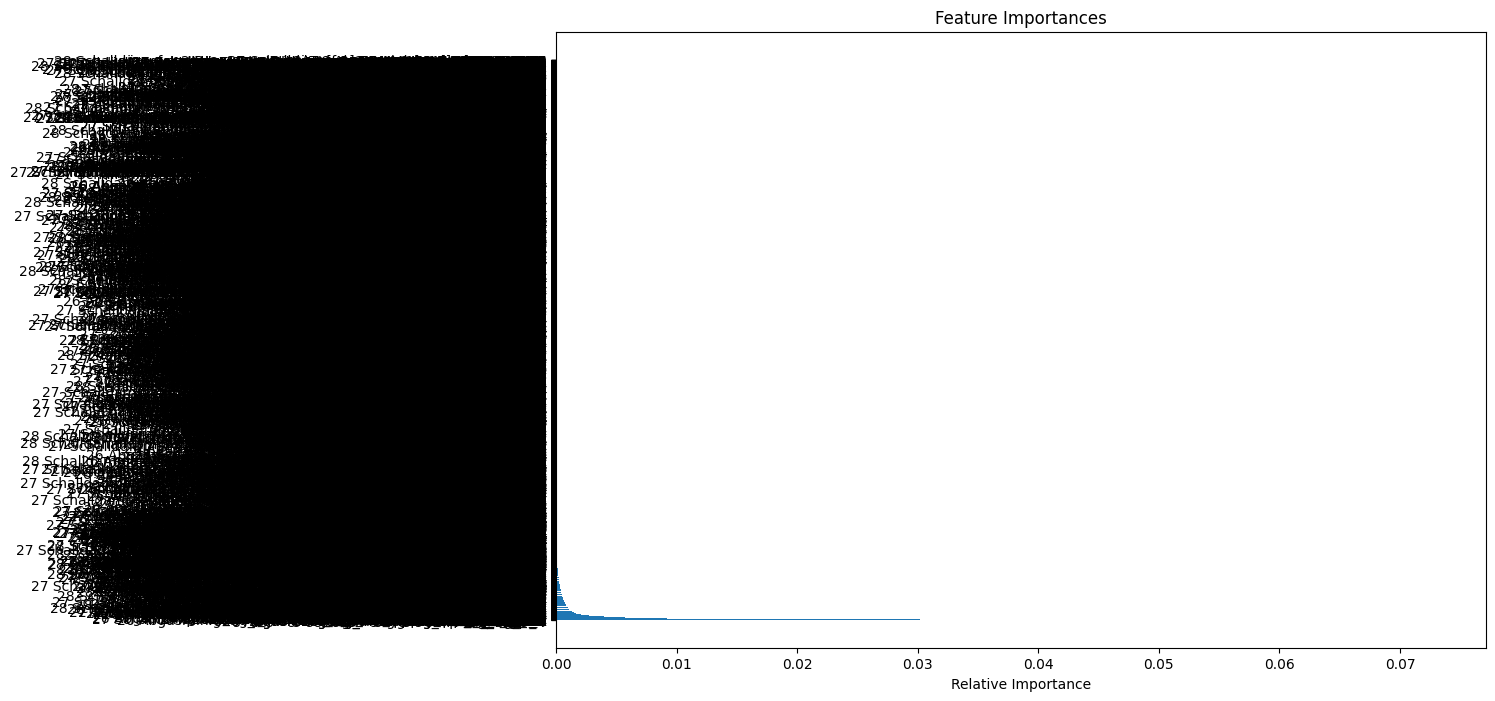

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


categorical_features = [
    '26 Abgasreinigung', '27 Schalldämpfer 1 Art', '27 Schalldämpfer 1 Bez', '28 Schalldämpfer 2 Art',
    '28 Schalldämpfer 2 Bez', 'Motormarke', 'Motortyp', 'Bauart', 'Treibstoff'
]

clean_categorical_features = [col for col in categorical_features if merged_data[col].dtype == 'object']

onehot_encoder = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', onehot_encoder, clean_categorical_features)
    ],
    remainder='drop'
)

X = merged_data.drop('ET-CO', axis=1)
y = merged_data['ET-CO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train_transformed, y_train)

y_pred = rf.predict(X_test_transformed)

mse = mean_squared_error(y_test, y_pred)

importances = rf.feature_importances_

feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=clean_categorical_features)

feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

print(feature_importances)

Mean Squared Error: 1553932.9729907003


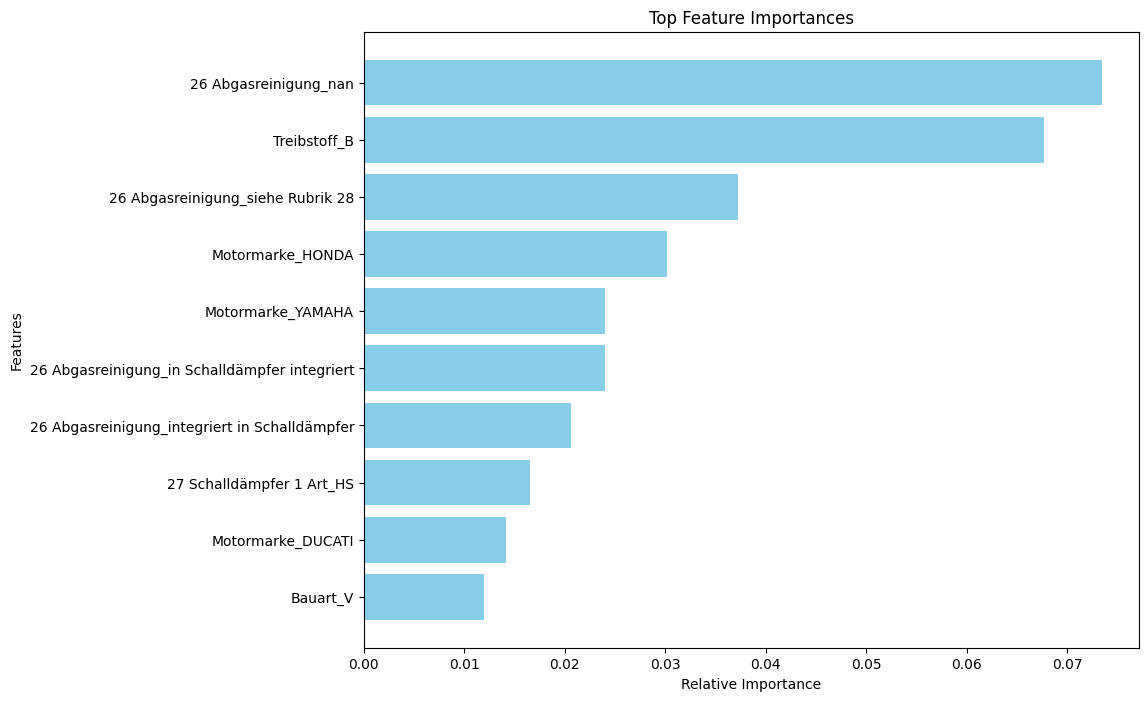

In [16]:
print(f'Mean Squared Error: {mse}')


top_n = 10
top_features = feature_importances.sort_values('importance', ascending=False).head(top_n)

plt.figure(figsize=(10, 8))
plt.title('Top Feature Importances')
plt.barh(top_features['feature'], top_features['importance'], align='center', color='skyblue')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.yticks(top_features['feature'])
plt.gca().invert_yaxis()
plt.show()

# Conclusion

The ten most important features for predicting the emission levels of a motorcycle - as identified by the Random Forest model - are somewhat surprising.

- The top predictor is "Abgasreinigung" or catalytic converter. When the value is NaN, that means that there is no information on the type of converter used, i.e. there isn't one. This was expected.
- "Treibstoff" or fuel type is a close second, which is unexpected, considering that most motorcycles use regular gas, not diesel.
- Honda, Yamaha and Ducati appear to on the list of motorcycle manufacturers. This does not mean that these manufacturers are the ones with highest emissions, only that they have a significance in predicting the emissions.
- The exhaust type made it to the top ten list of predictors, albeit its importance still seems to be rather low over all.